In [470]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, random
from scipy.stats import norm
from scipy.optimize import minimize
import time
from sklearn.ensemble import RandomForestRegressor
import yfinance as yf
from sklearn.covariance import ShrunkCovariance, empirical_covariance, log_likelihood
from pypfopt.efficient_frontier import EfficientFrontier, EfficientCVaR
from pypfopt import risk_models, expected_returns, CLA, plotting
from pypfopt.risk_models import CovarianceShrinkage

In [367]:
!pip install PyPortfolioOpt

   ---------------------------------------- 0.0/62.7 kB ? eta -:--:--
   ---------------------------------------  61.4/62.7 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------  61.4/62.7 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 62.7/62.7 kB 672.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ------------------- -------------------- 0.6/1.1 MB 17.8 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 14.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/72.2 kB ? eta -:--:--
   ---------------------------------------- 72.2/72.2 kB 3.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/887.3 kB ? eta -:--:--
   --------------------------------------  880.6/887.3 kB 27.2 MB/s eta 0:00:01
   --------------------------------------- 887.3/887.3 kB 18.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/303.1 kB ? eta -:--:--
   ------------------

In [121]:
SP500_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='SP500 Tech')
ftse_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='Vanguard FTSE')
gold_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='Gold ETF')
alphabet_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='Alphabet')
IAG_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='IAG')

In [312]:
#add more from yFiance daily data like the m* data
iShares_EM = yf.download('0P0000WGSW.L', start='2019-06-22')['Close'] 
schroders_Asia = yf.download('0P0000ZSYD.L', start='2018-06-22')['Close'] 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [323]:
def construct_df(df, yf = False):
    if yf == False:
        df = df.set_index('Unnamed: 0')         
        df = df.rename(columns={df.columns[0]: 'Close'}) 
    if yf == True:
        df = df.rename(columns={df.columns[0]: 'Close'})
    df['Returns'] = df['Close'].pct_change()  
    df['Volatility'] = df['Returns'].rolling(window=252).std() * np.sqrt(252)
    df['CumProd'] = 100*(1+df['Returns']).cumprod()
    return df.fillna(0)


def getDrawdowns(cumprod):
    peak = cumprod.cummax()
    drawdowns = (cumprod - peak) / peak
    return drawdowns

def getHistoricalVAR(df, level = 5):
    return np.percentile(df['Returns'].dropna(), level)

def getParametricVAR(df, level =5):
    mu = df['Returns'].mean()
    sigma = df['Returns'].std()
    z = norm.ppf(level / 100)  
    return mu + z * sigma

def getCVaR(df, level = 5, VAR_historic=True):
    if VAR_historic:
        var = getHistoricalVAR(df, level)
    elif VAR_historic is False:
        var = getParametricVAR(df, level)
    else:
        raise ValueError("VAR_historic must be True (for Historical) or False (for Parametric)")

    return df['Returns'][df['Returns'] <= var].mean()

SP500 = construct_df(SP500_data)
FTSE = construct_df(ftse_data)
Alphabet = construct_df(alphabet_data)
Gold = construct_df(gold_data)
IAG = construct_df(IAG_data)
EM = construct_df(iShares_EM, True)
Asia = construct_df(schroders_Asia, True)

combined_df = pd.DataFrame({
    'SP500Tech': SP500['Returns'],
    'FTSE': FTSE['Returns'],
    'Alphabet': Alphabet['Returns'],
    'Gold': Gold['Returns'],
    'IAG': IAG['Returns'],
    'EM' : EM['Returns'],
    'AsiaIndex' : Asia['Returns']

})
covMatrix = combined_df.cov()

def portfolio_return(weights, returns):
    return np.dot(weights, returns.mean()) * 252 

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))

def sharpe_ratio(weights, returns, risk_free_rate=0.0354):
    port_return = portfolio_return(weights, returns)
    port_vol = portfolio_volatility(weights, returns.cov())
    return (port_return - risk_free_rate) / port_vol

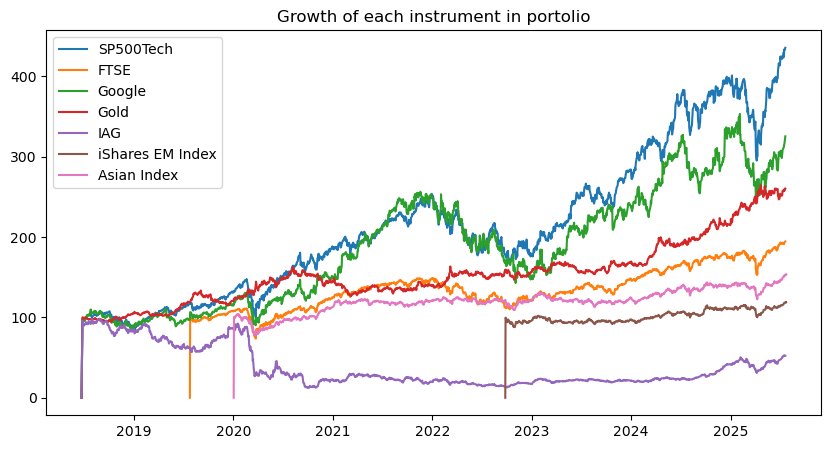

In [311]:
plt.figure(figsize =(10,5))
plt.plot(SP500.index, SP500['CumProd'], label = 'SP500Tech')
plt.plot(FTSE.index, FTSE['CumProd'], label = 'FTSE')
plt.plot(Alphabet.index, Alphabet['CumProd'], label = 'Google')
plt.plot(Gold.index, Gold['CumProd'], label = 'Gold')
plt.plot(IAG.index, IAG['CumProd'], label = 'IAG')
plt.plot(EM.index, EM['CumProd'], label = 'iShares EM Index')
plt.plot(Asia.index, Asia['CumProd'], label = 'Asian Index')
plt.legend()
plt.title('Growth of each instrument in portolio')
plt.show()

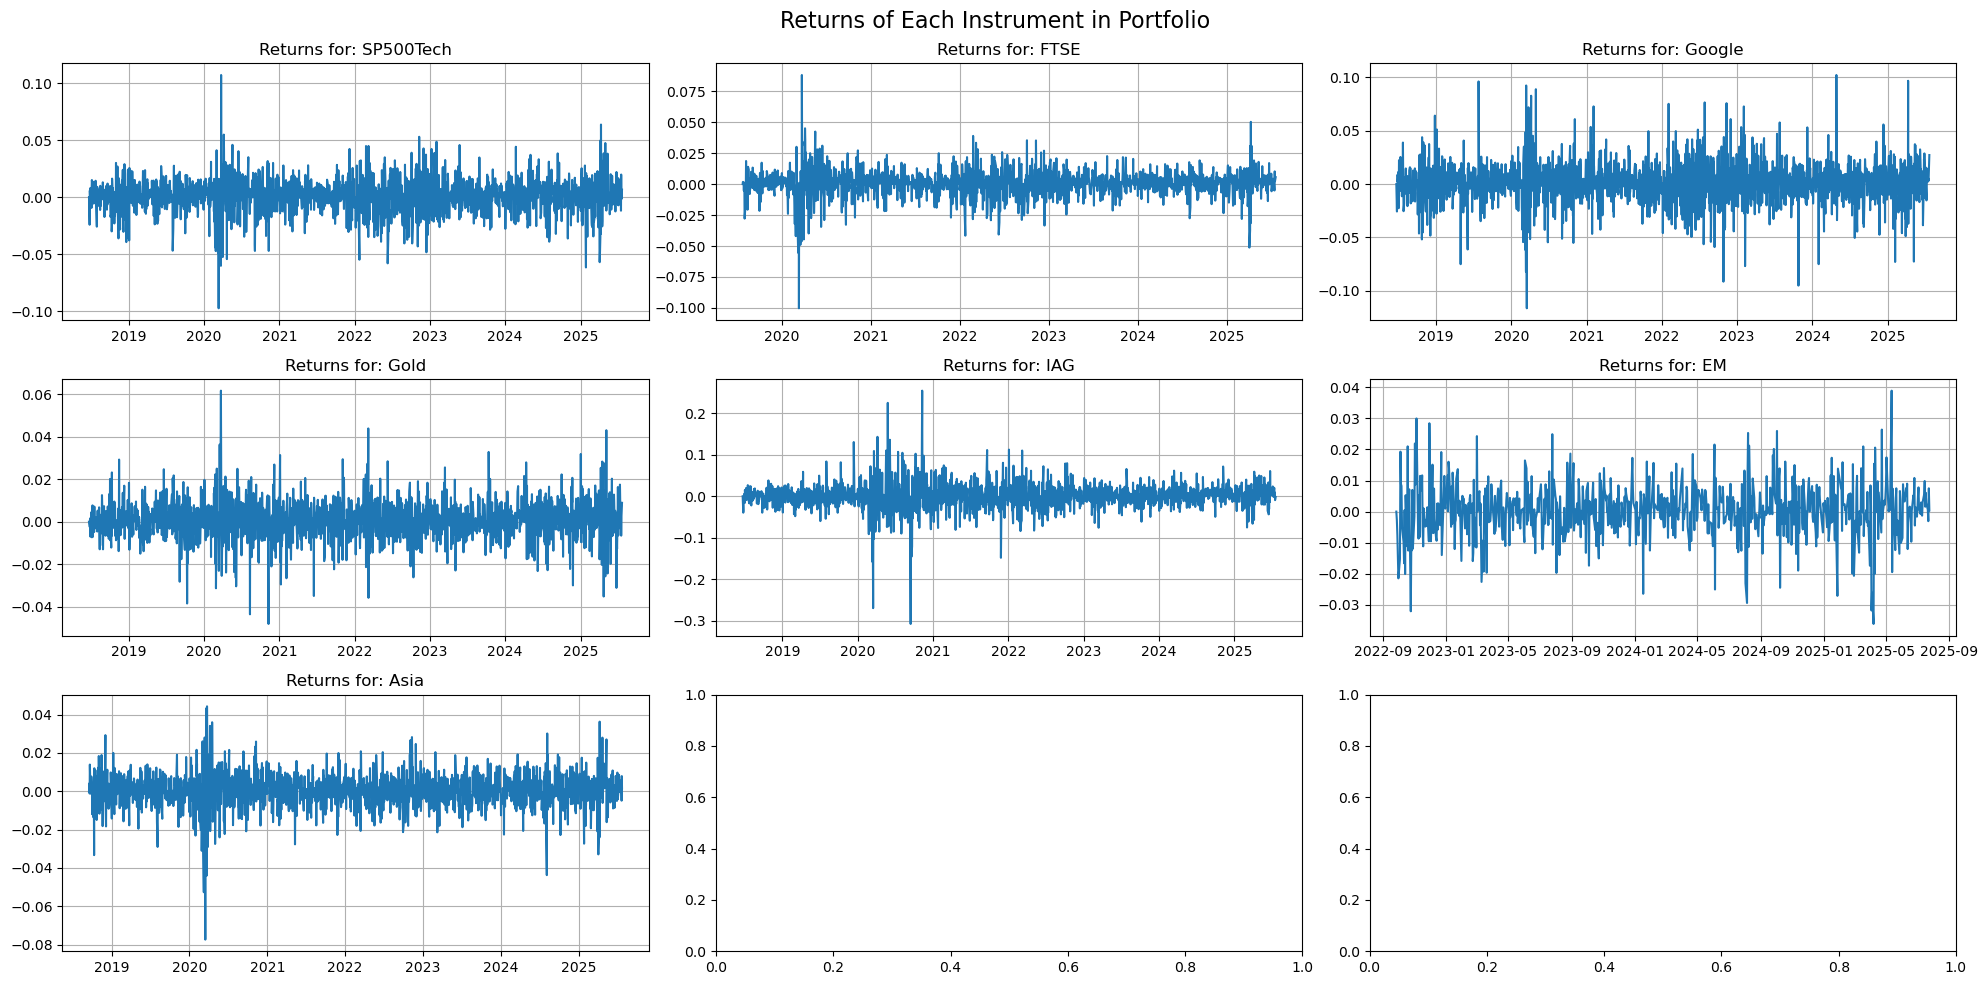

In [316]:
fig, ax = plt.subplots(3, 3, figsize=(20, 10))
axes = ax.flatten()

instruments = [('SP500Tech', SP500), ('FTSE', FTSE), ('Google', Alphabet), ('Gold', Gold), ('IAG', IAG), ('EM', EM), ('Asia', Asia)]
for i, (name, df) in enumerate(instruments):
    axes[i].plot(df.index, df['Returns'], label=name)
    axes[i].set_title(f'Returns for: {name}')
    axes[i].grid(True)


fig.suptitle('Returns of Each Instrument in Portfolio', fontsize=16)
plt.tight_layout()
plt.show()

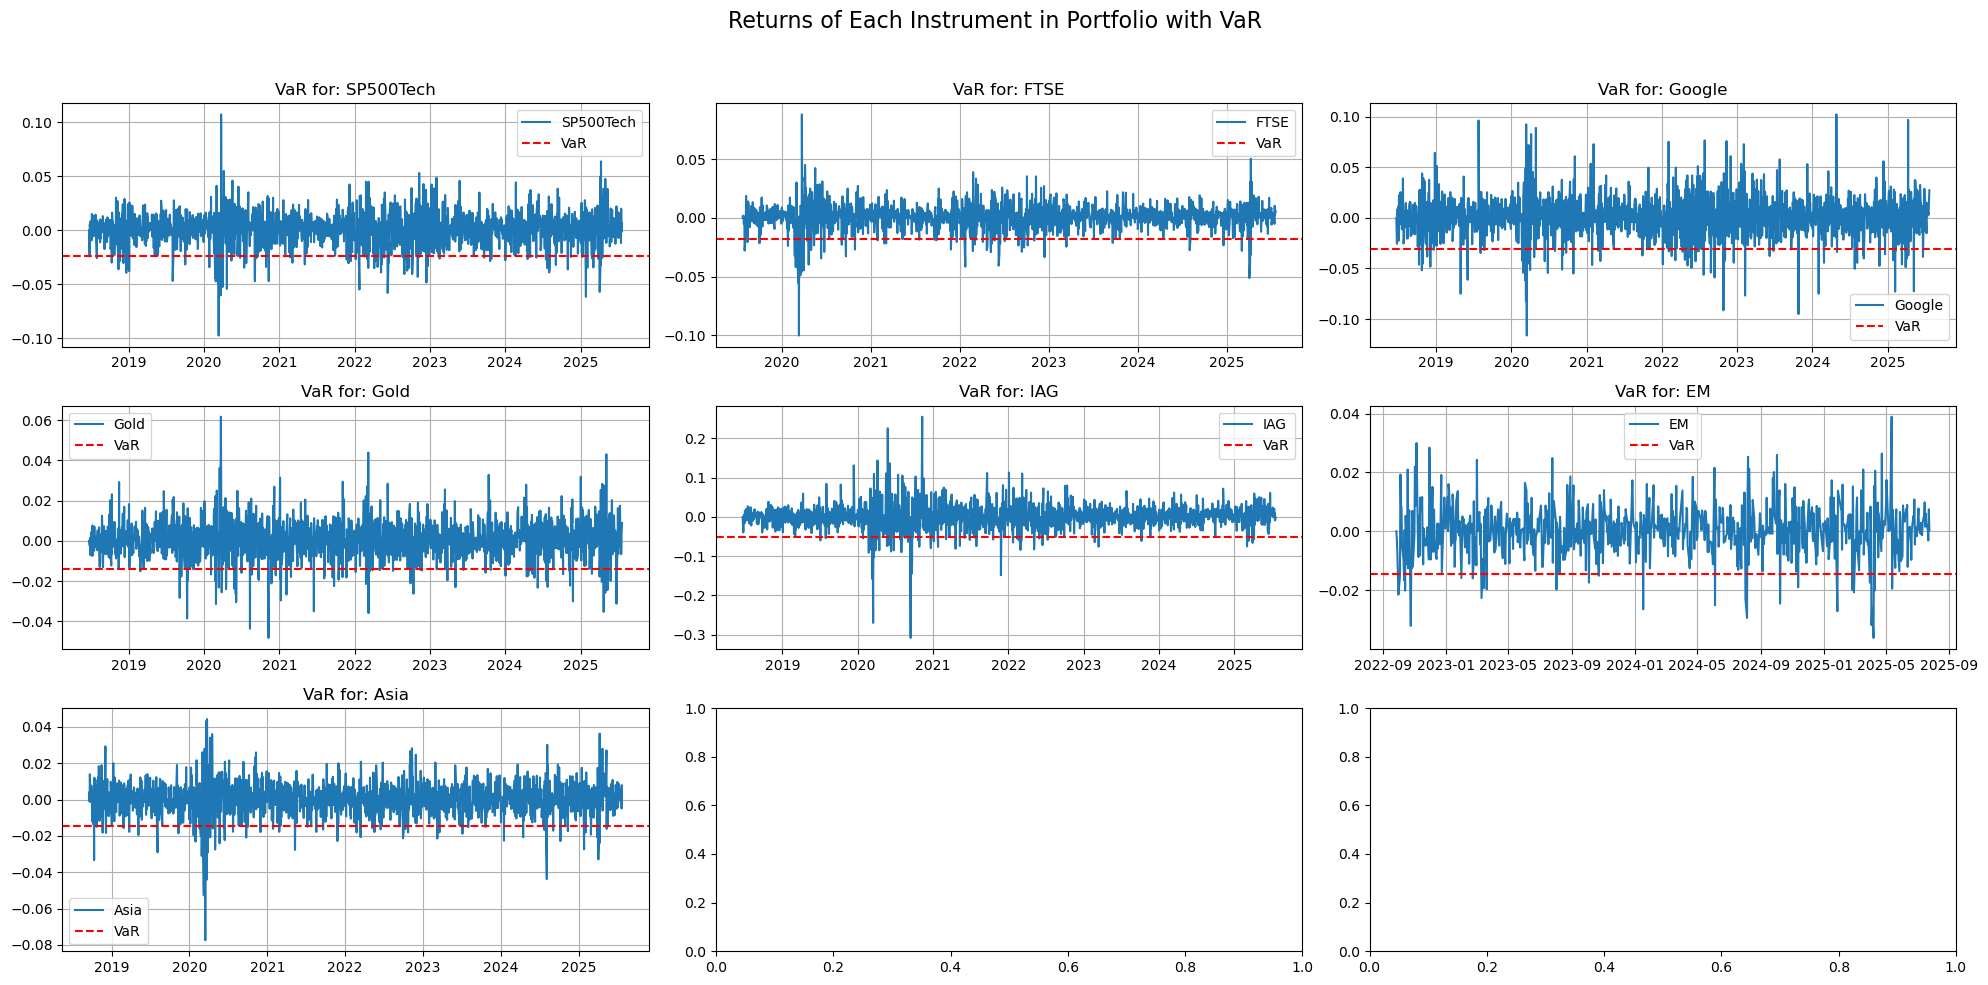

In [327]:
#again but with their historical VaR, then with CVaR both 95%.

def returns_with_risk_metrics(metric):
    fig, ax = plt.subplots(3, 3, figsize=(20, 10))
    axes = ax.flatten()

    instruments = [('SP500Tech', SP500), ('FTSE', FTSE), ('Google', Alphabet), ('Gold', Gold), ('IAG', IAG), ('EM', EM), ('Asia', Asia)]

    for i, (name, df) in enumerate(instruments):
        axes[i].plot(df.index, df['Returns'], label=name)
        if metric.lower() == 'var':
            risk_line = getParametricVAR(df)
            label = 'VaR'
        elif metric.lower() == 'cvar':
            risk_line = getCVaR(df, level=5, VAR_historic = True)
            label = 'CVaR (95%)'
        else:
            raise ValueError("metric must be 'VaR' or 'CVaR'")
        axes[i].axhline(risk_line, color='red', linestyle='--', label=label)
        axes[i].set_title(f'{metric} for: {name}')
        axes[i].grid(True)
        axes[i].legend()

    fig.suptitle(f'Returns of Each Instrument in Portfolio with {metric}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  
    plt.show()
returns_with_risk_metrics('VaR')

In [336]:
#get benchamrk data: 
benchmark_data = yf.download('^GSPC', start = '2018-06-22')['Close']
benchmark = construct_df(benchmark_data, yf = True)

[*********************100%***********************]  1 of 1 completed


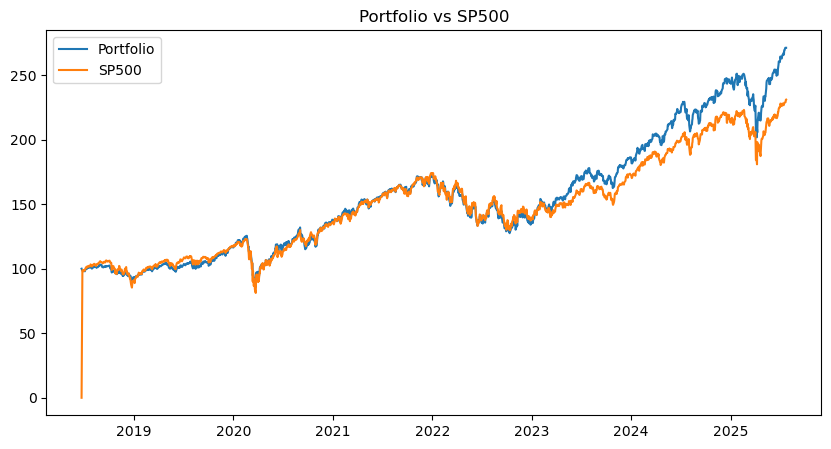

annulised portfolio volatility since 2018-06-22:  0.16872724613644413


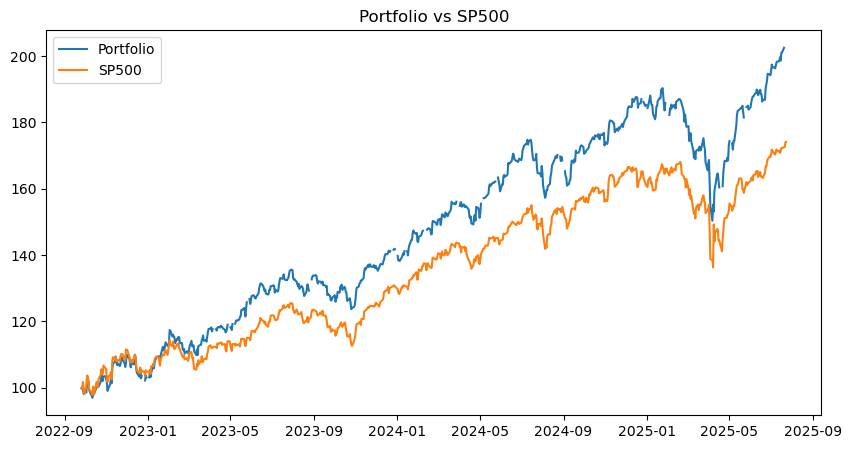

annulised portfolio volatility since 2022-09-06:  0.15751178249614675


In [358]:
weights = {
    'SP500Tech':0.4044,
    'FTSE': 0.3009,
    'Alphabet' : 0.0956,
    'Gold' : 0.0313,
    'IAG' : 0.0678,
    'EM' :0.0,
    'AsiaIndex': 0.00
} #as they stand today 

combined_df_start_date = combined_df.fillna(0) # fill nans with zeros so the portfolio start date starts at the actula start

weights_array = np.array([weights[col] for col in combined_df_start_date.columns])
portfolio_rets = combined_df_start_date.dot(weights_array)
portfolio_cumprod = 100*(1 + portfolio_rets).cumprod()
portfolio_drawdowns = getDrawdowns(portfolio_cumprod)

plt.figure(figsize=(10,5))
plt.plot(portfolio_cumprod, label='Portfolio')
plt.plot(benchmark.index, benchmark['CumProd'], label='SP500')
plt.title('Portfolio vs SP500')
plt.legend()
plt.show()
print('annulised portfolio volatility since 2018-06-22: ', portfolio_rets.std() * np.sqrt(252))
#------------- plot again but starting in 2022-09-26 when iShares Emerging market started.

portfolio_rets_22 = combined_df.dot(weights_array)
portfolio_cumprod_22 = 100*(1 + portfolio_rets_22).cumprod()
portfolio_drawdowns_22 = getDrawdowns(portfolio_cumprod_22)

benchmark_2022 = benchmark.loc['2022-09-26':]
benchmark_22_rebased = 100 * benchmark_2022 / benchmark_2022.iloc[0]
plt.figure(figsize=(10,5))
plt.plot(portfolio_cumprod_22, label='Portfolio')
plt.plot(benchmark_22_rebased.index, benchmark_22_rebased['CumProd'], label='SP500')
plt.title('Portfolio vs SP500')
plt.legend()
plt.show()
print('annulised portfolio volatility since 2022-09-06: ', portfolio_rets_22.std() * np.sqrt(252))

In [152]:
start = pd.Timestamp('2025-02-28')
print(start in benchmark_cumprod.index)

True


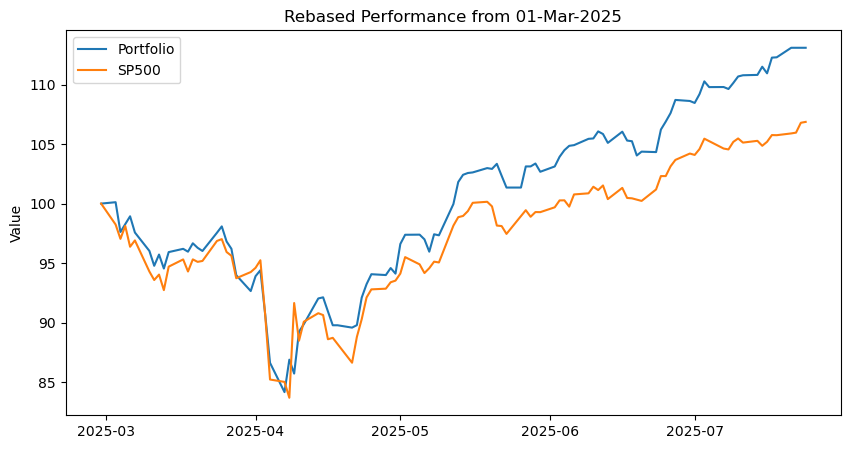

Sharpe Ratio: 0.89
Annual Volatility: 16.87%
Max Drawdown: -31.68%
CAGR: 114.51%
171.14599651126065


In [363]:
#rebase at 01-March-2025 (as when I started)
start ='2025-02-28'
pos = benchmark['CumProd'].index.get_indexer([start], method='nearest')[0]

portfolio_cumprod_rebased = portfolio_cumprod[start:] / portfolio_cumprod[start] * 100
benchmark_cumprod_rebased = benchmark['CumProd'].iloc[pos:] / benchmark['CumProd'].iloc[pos] * 100

plt.figure(figsize=(10, 5))
plt.plot(portfolio_cumprod_rebased, label='Portfolio')
plt.plot(benchmark_cumprod_rebased, label='SP500')
plt.title('Rebased Performance from 01-Mar-2025')
plt.ylabel('Value')
plt.legend()
plt.show()

sharpe_ratio = portfolio_rets.mean() / portfolio_rets.std() * np.sqrt(252)
volatility = portfolio_rets.std() * np.sqrt(252)
max_drawdown = portfolio_drawdowns.min()
cagr = (portfolio_cumprod.iloc[-1])**(252 / len(portfolio_cumprod)) - 1
tot_return = (portfolio_cumprod.iloc[-1] - portfolio_cumprod.iloc[0])

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Annual Volatility: {volatility:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"CAGR: {cagr:.2%}")
print(tot_return)

# The portfolio current weighting beats the market. Lets see if I can imporve this 

Finding EF:

In [422]:
SP500_data.iloc[:, 1].loc['2022-09-26':].reset_index
ftse_data.iloc[:, 1].loc['2022-09-26':].reset_index
gold_data.iloc[:, 1].loc['2022-09-26':].reset_index
alphabet_data.iloc[:, 1].loc['2022-09-26':].reset_index
IAG_data.iloc[:, 1].loc['2022-09-26':].reset_index
iShares_EM['0P0000WGSW.L'].loc['2022-09-26':].reset_index
schroders_Asia['0P0000ZSYD.L'].loc['2022-09-26':].reset_index

<bound method Series.reset_index of Date
2022-09-26    0.666881
2022-09-27    0.661254
2022-09-28    0.654836
2022-09-29    0.647099
2022-09-30    0.633295
                ...   
2025-07-18    0.834700
2025-07-21    0.836800
2025-07-22    0.832700
2025-07-23    0.839300
2025-07-24    0.840600
Name: 0P0000ZSYD.L, Length: 715, dtype: float64>

In [424]:
schroders_Asia['0P0000ZSYD.L'].loc['2022-09-26':].reset_index

<bound method Series.reset_index of Date
2022-09-26    0.666881
2022-09-27    0.661254
2022-09-28    0.654836
2022-09-29    0.647099
2022-09-30    0.633295
                ...   
2025-07-18    0.834700
2025-07-21    0.836800
2025-07-22    0.832700
2025-07-23    0.839300
2025-07-24    0.840600
Name: 0P0000ZSYD.L, Length: 715, dtype: float64>

In [441]:
EM

Ticker,Close,Returns,Volatility,CumProd
Date,,,,
2022-09-26,1.87353,0.000000,0.000000,0.000000
2022-09-27,1.86852,-0.002674,0.000000,99.732590
2022-09-28,1.85440,-0.007557,0.000000,98.978933
2022-09-29,1.82701,-0.014770,0.000000,97.516987
2022-09-30,1.78778,-0.021472,0.000000,95.423079
...,...,...,...,...
2025-07-18,2.21744,0.002736,0.155836,118.356250
2025-07-21,2.21890,0.000658,0.155346,118.434182
2025-07-22,2.21208,-0.003074,0.155368,118.070165


In [468]:
combined_price_df = pd.DataFrame({
    'SP500Tech': SP500['Close'],
    'FTSE': FTSE['Close'],
    'Alphabet': Alphabet['Close'],
    'Gold': Gold['Close'],
    'IAG': IAG['Close'],
    'EM' : EM['Close'],
    'AsiaIndex' : Asia['Close']

})
mu = expected_returns.mean_historical_return(combined_price_df)
e_cov = CovarianceShrinkage(combined_price_df).ledoit_wolf()
e_cov

C:\Users\MarcusConnolly\anaconda3\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(


,SP500Tech,FTSE,Alphabet,Gold,IAG,EM,AsiaIndex
SP500Tech,0.056466,0.031612,0.031971,-0.004493,0.035309,0.004059,0.014092
FTSE,0.031612,0.026585,0.018672,-0.002913,0.034767,0.002870,0.010774
Alphabet,0.031971,0.018672,0.093493,-0.001420,0.024779,0.001982,0.008327
Gold,-0.004493,-0.002913,-0.001420,0.020764,-0.012863,0.000807,0.000765
IAG,0.035309,0.034767,0.024779,-0.012863,0.237470,0.003100,0.019993
EM,0.004059,0.002870,0.001982,0.000807,0.003100,0.008252,0.005959
AsiaIndex,0.014092,0.010774,0.008327,0.000765,0.019993,0.005959,0.019219


Min volatility of each asset in portfolio OrderedDict({'SP500Tech': 0.0, 'FTSE': 0.14915595171187856, 'Alphabet': 0.018015826718336764, 'Gold': 0.2617303621650136, 'IAG': 0.005643583245596357, 'EM': 0.5654542761591748, 'AsiaIndex': 0.0})


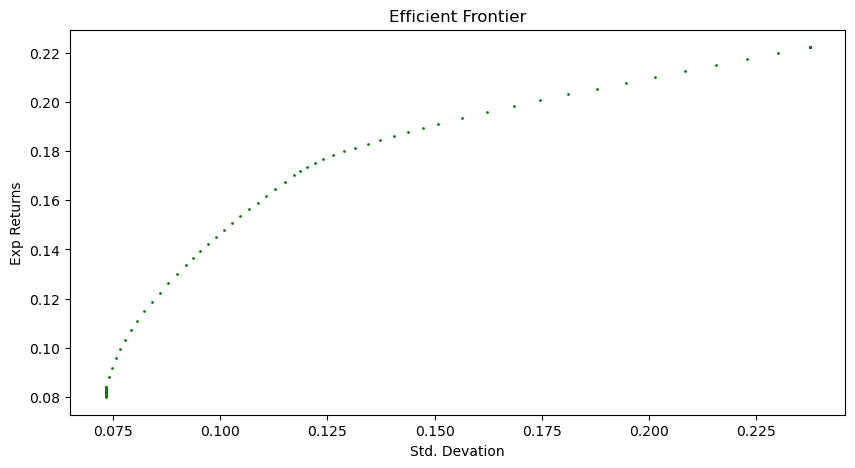

In [463]:
efficient_portfolio = CLA(mu, e_cov)
print('Min volatility of each asset in portfolio', efficient_portfolio.min_volatility())

(ret, vol, weights) = efficient_portfolio.efficient_frontier()
plt.figure(figsize =(10,5))
plt.scatter(vol, ret, s = 4, c = 'g', marker = '.')
plt.title('Efficient Frontier')
plt.ylabel('Exp Returns')
plt.xlabel('Std. Devation')
plt.show()

In [ ]:
ecvar = EfficientCVaR(None, combined_df) #returns df
optimal_weights = ecvar.min_cvar()

assets = ['SP500Tech','FTSE','Alphabet','Gold','IAG','EM','AsiaIndex']
optimal_weights = {assets[i] : optimal_weights[i] for i in optimal_weights}

print(optimal_weights)

{'SP500Tech': 5.47956e-11, 'FTSE': 0.2483499187311031, 'Alphabet': 0.0279409678081489, 'Gold': 0.4674236931734465, 'IAG': 0.0540891007977243, 'EM': 0.0496036454537057, 'AsiaIndex': 0.1525926739810758}


C:\Users\MarcusConnolly\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:149: UserWarning: Removing NaNs from returns
  warnings.warn(


OrderedDict({'SP500Tech': 0.27940435164834515, 'FTSE': 7.914906900154882e-18, 'Alphabet': 0.043842198869055646, 'Gold': 0.5239544127480581, 'IAG': 0.0, 'EM': 0.15279903673454118, 'AsiaIndex': 0.0})
Expected annual return: 15.0%
Annual volatility: 10.2%
Sharpe Ratio: 1.47


<Axes: xlabel='Volatility', ylabel='Return'>

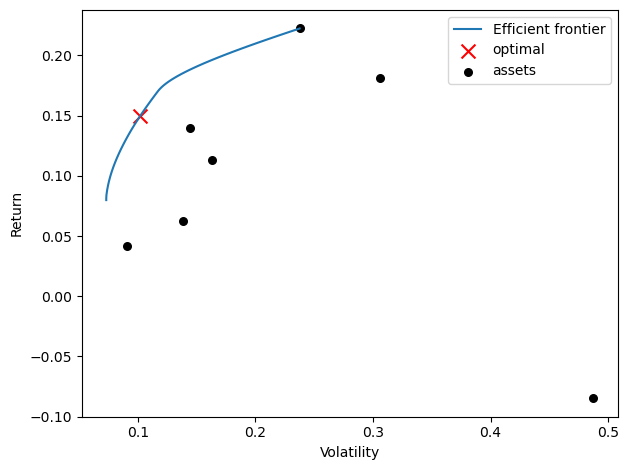

In [476]:
cla = CLA(mu, e_cov)
print(cla.max_sharpe()) # optimal weights for max sharpe value
cla.portfolio_performance(verbose=True)
plotting.plot_efficient_frontier(cla)

#Forecasts
- starting at base value of £5,000.